# Exploratatory Analysis of the GECKO-A data set (starting with single experiment)

Omar Chaarawi, David John Gagne, John Schreck, Charlie Becker


Before we can apply any machine learning techniques, we must gather, prepare and explore the data available. Data is almost always presented in a way that makes building a model difficult if not impossible. This can be due to missing data, incorrect data types, variability in values between features that make modeling difficult, or any other number of reasons. We're going to start with loading the dataset. Then we will do some initial analysis of the data. How is it typed? What is the [Tukey 5-number Summary](https://machinelearningmastery.com/how-to-calculate-the-5-number-summary-for-your-data-in-python/#:~:text=The%20five%2Dnumber%20summary%2C%20or,for%20data%20with%20any%20distribution.)? How is the data distributed? Are the data in the features correlated? Then we move on to how we can scale and normalize the data to better help our algorithms solve for a model that can hopefully generalize well.

## Introduction
![GECKO](gecko_image.png)
Natural and anthropogenic sources emit a large number of volatile organic compounds (VOCs). These compounds greatly affect the “self-cleaning capacity” of the atmosphere. These compounds can also undergo complicated chemical and physical processes in the atmosphere, forming organic aerosols. Organic aerosols have significant direct (absorbing/scattering) and indirect (affect cloud formation/properties) radiation effect.

In order to understand the broad impacts of VOCs on air quality and climate, we need to understand their sources and fates in the atmosphere. Many of these compounds can be directly emitted, or be produced from other compounds; in the meantime, they can undergo a variety of chemical reactions in the atmosphere. The chemical mechanism of these VOCs in the atmosphere can be very highly complicated, especially involving the formation of organic aerosols.

Most air quality models or chemistry-climate models are equipped with chemical mechanisms consisting of hundreds-thousands of chemical reactions. It is often found that such simplified chemical mechanisms are incapable to describe the complicity in the atmosphere. A widely used “near-explicit” chemical mechanism (Master Chemical Mechanism) consists of tens of thousands of chemical reactions, which still cannot capture the behavior and characteristics of the formation of organic aerosols. Such “near-explicit” mechanism is too computationally demanding for most air quality models or chemistry-climate models already.

NCAR (USA) and Centre National de la Recherche Scientifique (CNRS, France) jointly developed a hyper-explicit chemical mechanism: Generator of Explicit Chemistry and Kinetics of Organics in the Atmosphere (GECKO-A). GECKO-A can generate chemical mechanisms based on how the molecules/bonds/atoms interact with each other. Chemical mechanisms generated by GECKO-A usually include millions to tens of millions of reactions. Due to the remarkable computational cost, no air quality models or chemistry-climate models can afford to run with GECKO-A in the foreseeable future. There is a growing interest in the community to implement such complicated mechanisms into air quality models or chemistry-climate models, to study the broader impacts on air quality, human health, and the climate system.

Machine‐learning and artificial intelligence have proven to be a valuable tool in atmospheric science. Recent years have seen quite a few inspiring applications in developing machine-learning emulators using explicit/process-level models and implementing the trained emulators into large-scale models. Such explicit/process-level models are otherwise too expensive for large-scale models.

The goal of this project is to train the machine-learning emulator using the “library” generated by the hyper-explicit chemical mechanism, GECKO-A. 


# First steps: Gathering the data

Data can be stored in a variety of ways with varying complexities and advantages. One very common way of storing data is as a csv file. CSV has the advantage of being human readable and easily accessible by a large variety of applications, but with the caveat that csv files do not necessarily distinguish between text and numeric data. Data is also not typed so you cannot assume your application will automatically be able to distinguish between int, float, bool, text, etc.

Typically you would begin with loading the data and inspecting how the data are typed. Fortunately this has been done and so we can begin with loading the data from AWS into a Pandas dataframe. We will still go through some data inspection for educational purposes.

### Some notes about the data:
GECKO-A runs simulations of precursors under a variety of different conditions for 5 days at 5 minute increments. This generates a large amount of data and we will be dealing with a small snippet at first to ease into things. At the time this notebook was written our options for precursor were toluene, alpha-pinene, and dodecane. We're starting with toluene.


In [1]:
# We will need several popular data science tools for this notebook
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn
import sklearn.decomposition
import scipy
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.decomposition import PCA
import s3fs
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline

In [2]:
def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

In [3]:
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]

The dataset we will be working with is the toluene binned data. Binned in this case refers to bins of gas and aerosol data split by volatility. There is also an aggregated dataset where the gas and aerosol data are combined by summing. For example if there were 14 bins each with 1 unit of gas, the aggregated data would show only 1 bin of 14 units of gas. 

In [4]:
"""Fetch the data by filename. We are fetching the toluene training data input as a parquet. 
Parquet's are a compact way to store data typed. (Typed meaning each data type is specified already)"""

dataFrame = fetch_data('ncar-aiml-data-commons/gecko/toluene_train_in_binned.parquet')

In [5]:
dataFrame_single_experiment = dataFrame[dataFrame["id"] == 'Exp0']

In [6]:
dataFrame_single_experiment.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,Gas [ug/m3] Bin05: lg(C*) = -2.5,Gas [ug/m3] Bin06: lg(C*) = -1.5,Gas [ug/m3] Bin07: lg(C*) = -0.5,Gas [ug/m3] Bin08: lg(C*) = 0.5,...,Aerosol [ug_m3] Bin12: lg(C*) = 4.5,Aerosol [ug_m3] Bin13: lg(C*) = 5.5,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.037689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,305.065364,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
1,301.207794,0.037426,2.767639e-17,5.465436e-13,1.420820e-12,4.041857e-12,4.353356e-12,5.635269e-12,6.116312e-12,1.709608e-10,...,1.133111e-11,1.206304e-13,5.079438e-12,304.978044,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
2,601.415588,0.037164,2.772026e-17,5.440976e-13,1.415403e-12,4.287764e-12,4.421259e-11,1.623398e-11,2.802625e-11,1.634808e-09,...,2.606058e-11,4.502163e-13,5.588369e-12,304.890766,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
3,901.623352,0.036904,2.772170e-17,5.417454e-13,1.413397e-12,5.737255e-12,1.927043e-10,4.042448e-11,8.991534e-11,5.784281e-09,...,4.304783e-11,9.602400e-13,6.075447e-12,304.803571,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
4,1201.831177,0.036646,2.803421e-17,5.397588e-13,1.422216e-12,1.059735e-11,5.276418e-10,8.292556e-11,2.145164e-10,1.374481e-08,...,6.160334e-11,1.625196e-12,6.543917e-12,304.716502,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0


Already we can see what columns are included in the data and get an idea of variablity in scale. Let's do some further formal investigation.

To see all the info available about a data frame you can use the built-in info function. We can see that all the data is fortuntately typed as float data. 

In [7]:
dataFrame.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302400 entries, 0 to 2302399
Data columns (total 37 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   Time [s]                              float64
 1   Precursor [ug/m3]                     float64
 2   Gas [ug/m3] Bin01: lg(C*) = -6.5      float64
 3   Gas [ug/m3] Bin02: lg(C*) = -5.5      float64
 4   Gas [ug/m3] Bin03: lg(C*) = -4.5      float64
 5   Gas [ug/m3] Bin04: lg(C*) = -3.5      float64
 6   Gas [ug/m3] Bin05: lg(C*) = -2.5      float64
 7   Gas [ug/m3] Bin06: lg(C*) = -1.5      float64
 8   Gas [ug/m3] Bin07: lg(C*) = -0.5      float64
 9   Gas [ug/m3] Bin08: lg(C*) =  0.5      float64
 10  Gas [ug/m3] Bin09: lg(C*) =  1.5      float64
 11  Gas [ug/m3] Bin10: lg(C*) =  2.5      float64
 12  Gas [ug/m3] Bin11: lg(C*) =  3.5      float64
 13  Gas [ug/m3] Bin12: lg(C*) =  4.5      float64
 14  Gas [ug/m3] Bin13: lg(C*) =  5.5      float64
 15  Gas [ug/m3] Bin

A really simple way to get idea of scale of date is to use the describe function.

In [8]:
dataFrame_single_experiment.describe()

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,Gas [ug/m3] Bin05: lg(C*) = -2.5,Gas [ug/m3] Bin06: lg(C*) = -1.5,Gas [ug/m3] Bin07: lg(C*) = -0.5,Gas [ug/m3] Bin08: lg(C*) = 0.5,...,Aerosol [ug_m3] Bin11: lg(C*) = 3.5,Aerosol [ug_m3] Bin12: lg(C*) = 4.5,Aerosol [ug_m3] Bin13: lg(C*) = 5.5,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
count,1439.000000,1439.000000,1.439000e+03,1.439000e+03,1.439000e+03,1.439000e+03,1.439000e+03,1.439000e+03,1.439000e+03,1439.000000,...,1.439000e+03,1.439000e+03,1.439000e+03,1.439000e+03,1439.000000,1439.000000,1.439000e+03,1.439000e+03,1439.000000,1.439000e+03
mean,215850.396093,0.003733,2.021360e-13,5.556259e-11,1.082717e-09,3.945749e-07,3.174565e-07,7.621485e-08,5.025162e-08,0.000014,...,2.073492e-10,1.353163e-09,1.208081e-11,2.453915e-12,305.065668,52.072802,1.991367e-02,8.859859e+01,1.938279,4.259464e+00
std,124750.693195,0.007519,1.838049e-13,4.849722e-11,9.527305e-10,2.566459e-07,2.946948e-07,2.868260e-08,8.170075e-08,0.000012,...,1.001216e-10,7.035044e-10,2.214525e-11,4.616288e-12,2.829415,0.000000,3.470653e-18,1.421580e-14,0.000000,8.884872e-16
min,1.000000,0.000002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,301.065671,52.072802,1.991367e-02,8.859859e+01,1.938279,4.259464e+00
25%,107925.699219,0.000019,3.767253e-14,1.203819e-11,2.407222e-10,1.864725e-07,1.008805e-07,5.163375e-08,5.407565e-10,0.000003,...,1.262642e-10,7.971119e-10,1.061825e-13,2.736842e-14,302.238781,52.072802,1.991367e-02,8.859859e+01,1.938279,4.259464e+00
50%,215850.390625,0.000241,1.324860e-13,3.813399e-11,7.260892e-10,3.065869e-07,1.682072e-07,7.579380e-08,5.899741e-09,0.000010,...,1.937927e-10,1.363832e-09,1.373512e-12,2.204578e-13,305.065364,52.072802,1.991367e-02,8.859859e+01,1.938279,4.259464e+00
75%,323775.093750,0.003017,3.707308e-13,1.009110e-10,1.960272e-09,6.300609e-07,4.314710e-07,1.003179e-07,6.977660e-08,0.000025,...,2.495751e-10,1.783337e-09,1.933484e-11,3.040743e-12,307.892556,52.072802,1.991367e-02,8.859859e+01,1.938279,4.259464e+00
max,431699.781250,0.037689,5.492116e-13,1.487578e-10,2.999862e-09,9.082035e-07,1.023356e-06,1.182078e-07,3.053565e-07,0.000036,...,5.173409e-10,3.123797e-09,9.653937e-11,1.888794e-11,309.065666,52.072802,1.991367e-02,8.859859e+01,1.938279,4.259464e+00


### Data Columns

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Time  | seconds     | Varies | 
| Precursor  | ug/m3     | Varies | 
| Gas bins separated by volatatility  | ug/m3     | Varies   |
| Aerosol bins separated by volataility   | ug/m3     | Varies |
| Temperature   | K     | Static         |
| Solar Zenith Angle   | degree     | Static        |
| Pre-existing Aersols   | ug/m3     | Static         |
| o3  | ppb     | Static         |
| nox   | ppb     | Static         |
| oh   | 10^6 molec/cm3     | Static         |

A quick way to see how the data are distributed is to plot histograms of the data.

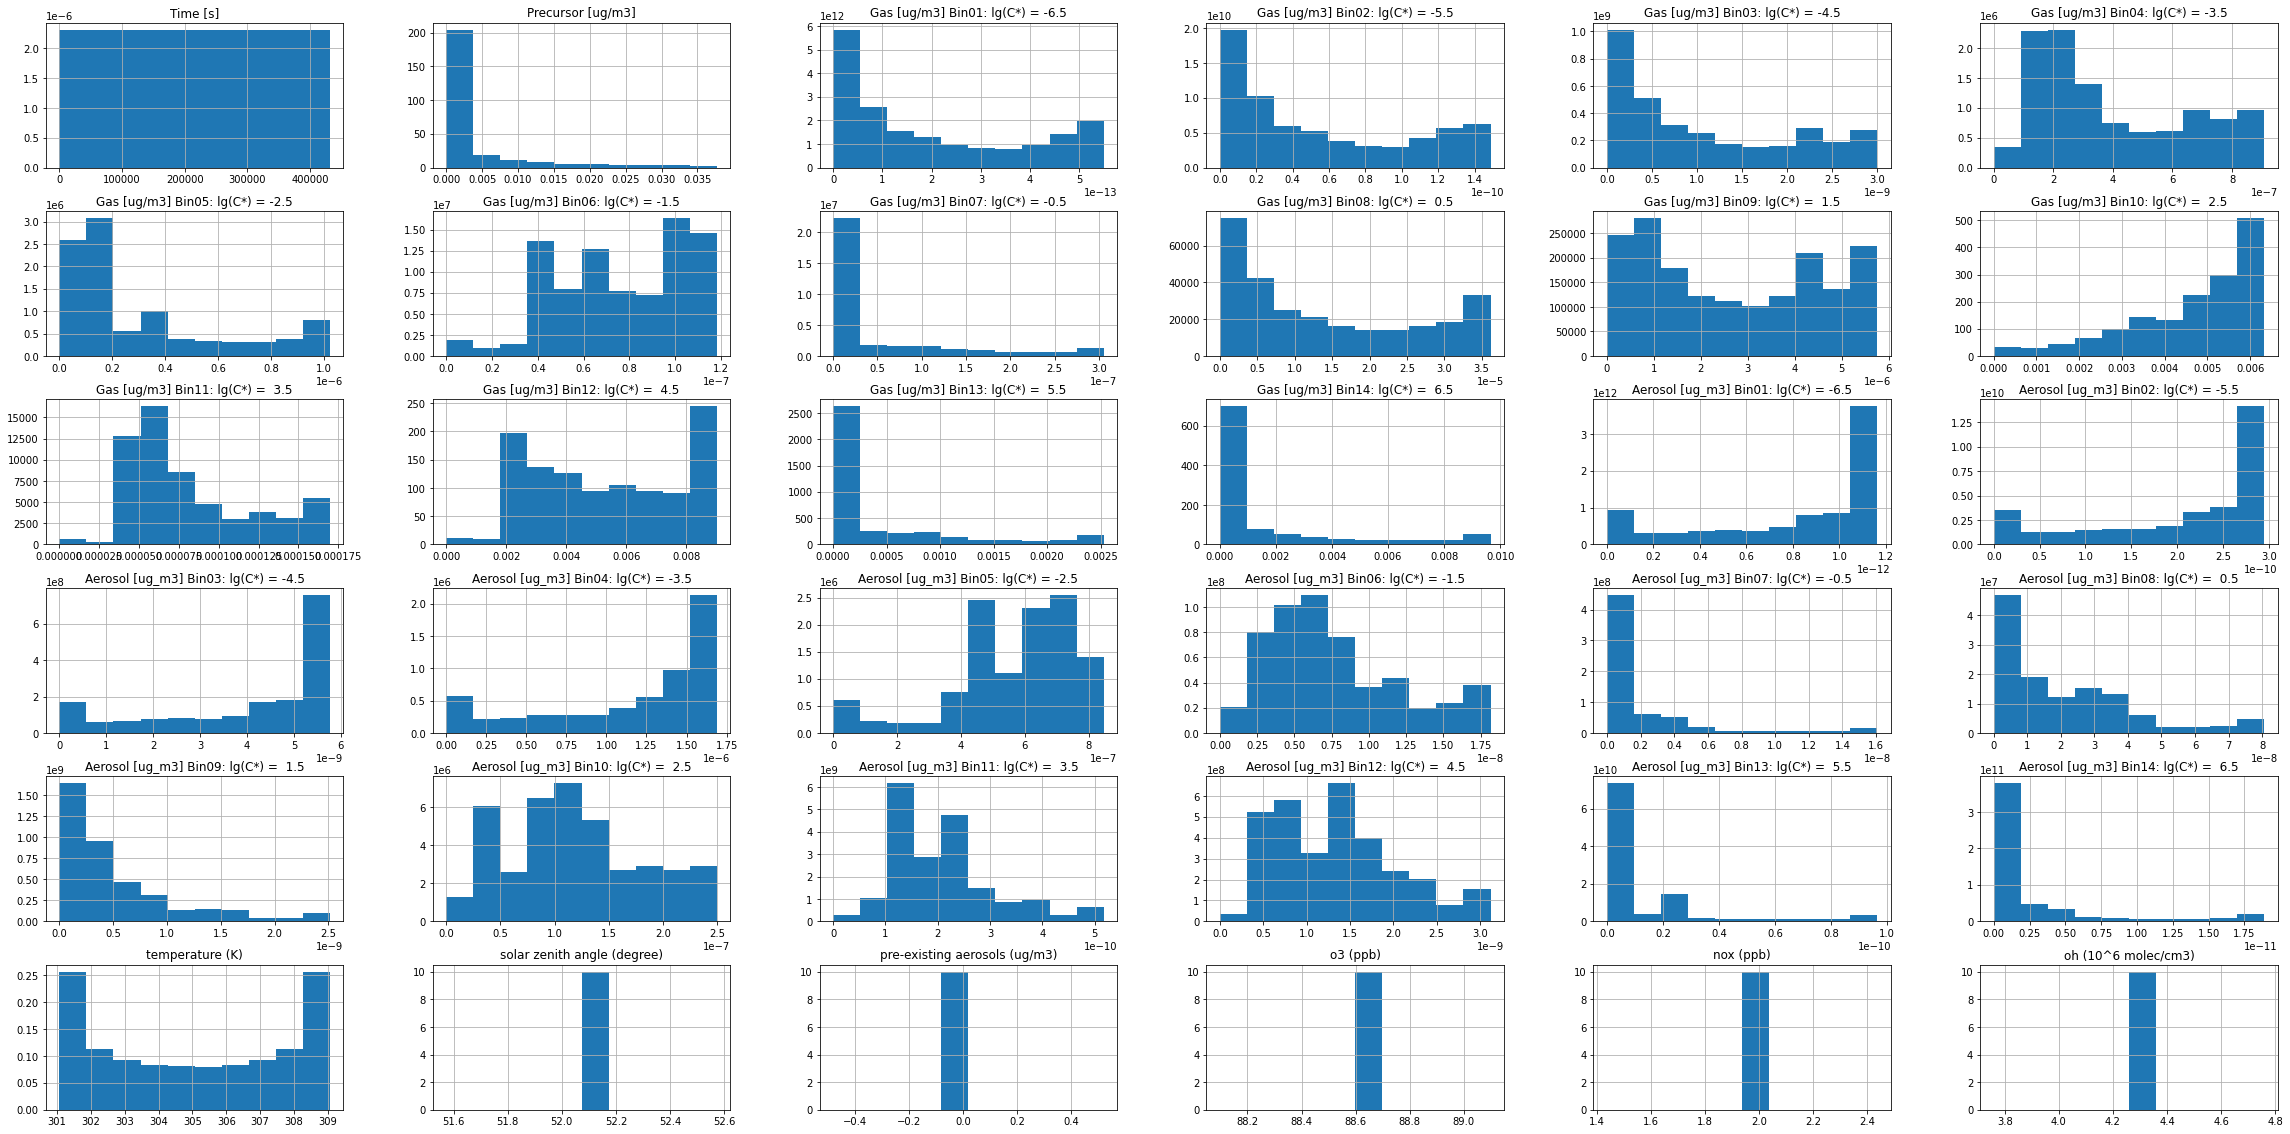

In [9]:
_ = dataFrame_single_experiment.hist(figsize=(40,20), density = True)

### Stop and ask:

Now is a good time to pause and look at the plots of the data. Start to ask questions like: how are the data distributed? what variables change? what is the scale of the data? do some columns seem to overpower others by their scale?

These are important questions to think about before diving into developing a model. Things like scale and distribution change how a model will perform. Solving for a model is a lot like trying to find the lowest point on a surface. If the scale of the data is too inconsistent it takes more work to find that lowest point or your algorithm may even diverge.

## Data Preparation: Normalizing data

It's important to normalize and scale data because it makes it easier to solve for a local minima when evaluating the surface of the cost function for our model using gradient descent. Think of normalizing as smoothing the surface of the cost function. More information on scaling and normalizing [here.](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35#:~:text=Feature%20scaling%20is%20essential%20for,that%20calculate%20distances%20between%20data.&text=Since%20the%20range%20of%20values,not%20work%20correctly%20without%20normalization.)

### A visual of scaling effects

Let's plot the values for precursor for a single experiment.

In [10]:
def plot_feature(data, feature):
    _ = plt.plot(data[feature])
    plt.title(f'Distribution of {feature} for Single Experiment')
    plt.xlabel('Time Step in 5 minute increments')
    plt.ylabel(feature)

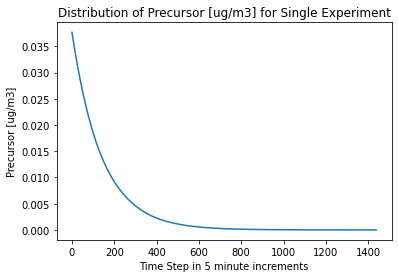

In [11]:
dataFrame = dataFrame_single_experiment
_ = plot_feature(data=dataFrame, feature="Precursor [ug/m3]")

Notice that precursor follows an exponential decay distribution. How about we take a look at another column. Let's look at temperature next.

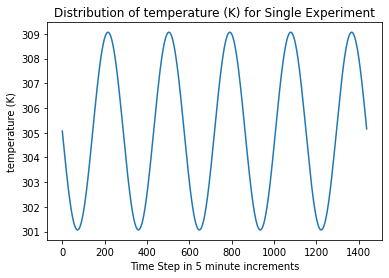

In [12]:
_ = plot_feature(data=dataFrame, feature="temperature (K)")

Temperature is distributed differently. This is because temperature was fluctuated to emulate changing temperature throughout the day. In other words temperature data is diurnal.

Next let's look at how gas an aerosol data is distributed.

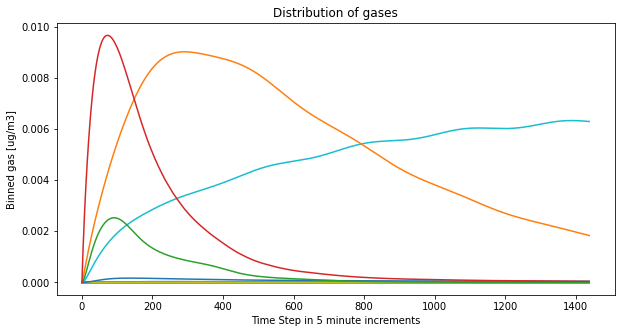

In [13]:
plt.figure(figsize=(10,5))

gas_binned = dataFrame_single_experiment.columns[2:16]
for item in gas_binned:
    _ = plot_feature(dataFrame_single_experiment, feature = item)
    plt.title("Distribution of gases")
    plt.ylabel("Binned gas [ug/m3]")
    
plt.show()

Not all bins of gas data are distributed in the same way. This poses an interesting problem for aggregating the bins. We will look at PCA (Principal Component Analysis) as one way of reducing the dimension of the bins. 

## Stop and Ask

In [14]:
# TODO

# Start to think about how the binned aersol data might be distributed. 
# Plot the data as shown above. Start to ask questions about how gas an aersol data is correlated.

# Your code here

Something you might also consider is: how might we transform the data to fit something that is more friendly to machine learning models. How might we transform the "Precursor [ug/m3]" column for example? One thing we could try is a log transform. Later, in notebook two we will see the benefits of performing a log transform prior to training a model.

In [15]:
# TODO

# log transform the Precursor column and plot the data

# Your code here

### Scale

Scale is important to take into consideration in machine learning because certain machine learning algorithms perform better when data is first scaled. There are two references that help explain this topic. ["Toward Data Science"](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35) and this [Coursera course](https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-i-feature-scaling-xx3Da) both offer great explanations of why you should scale your data in certain circumstances. We will use a Z-score standardization below.

A Z-score standardization is represented in the following way:

$x' = \frac{x - \bar{x}}{\sigma}$ , where ${x}$ is the original feature vector, ${\bar {x}}={\text{average}(x)}$ is the mean of that feature vector, and ${\displaystyle \sigma }$ is its standard deviation.

There are many other types of scaling and normalization techniques.

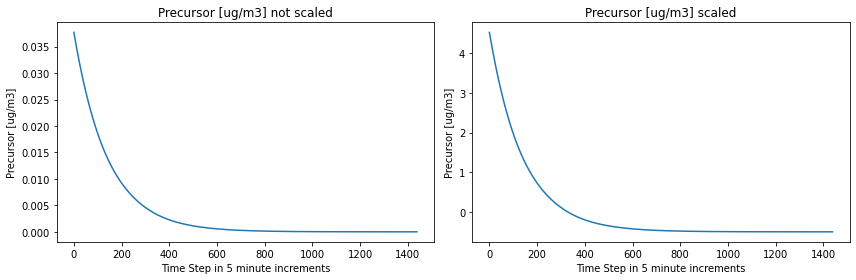

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_feature(data = dataFrame_single_experiment, feature="Precursor [ug/m3]")
plt.title("Precursor [ug/m3] not scaled")

dataFrame_single_experiment_scaled = dataFrame_single_experiment
dataFrame_single_experiment_scaled[["Precursor [ug/m3]"]] = StandardScaler().fit_transform(dataFrame_single_experiment[["Precursor [ug/m3]"]])
plt.subplot(1,2,2)

plot_feature(data=dataFrame_single_experiment_scaled, feature="Precursor [ug/m3]")
plt.title("Precursor [ug/m3] scaled")

plt.tight_layout()
plt.show()

Notice how maintained the data distribution but changed the scale from (0 to 0.035) to (0 to 4.5). This is a much better scale.

## Stop and Ask

Try some different scaling methods. [Here](https://scikit-learn.org/stable/modules/preprocessing.html) are some expamples of scaling methods built-in to sklearn. Try plotting some features together and notice how scaling brings the data into the same reference frame while conserving each invividual columns distribution.

# Further analysis (PCA)

One way to transform data is by performing PCA. PCA reduces the dimension of the data matrix making it easier to both visualize and later use in machine learning algorithms such as linear regression. You can read more about what PCA is and how it works [here](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c).

Let's only choose some columns to predict if passenger's were likely to survive or not. We will pick: Pclass, Sex, Age, SibSb, Parch, and Fare. The remaining columns aren't really relevant to predicting survival rates. We will also remove any rows with missing data. Next we will convert Sex to a int with 0 being male and 1 being female. We will process the data in the below cells before moving on to a PCA demonstration. 

In [17]:
dataFrame_titanic = pd.read_csv("./titanic_data.csv")
dataFrame_titanic.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,4.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,24.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,23.0,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,NaN,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,NaN,0,0,370376,7.75,NaN,Q


In [18]:
dataFrame_titanic_PCA = dataFrame_titanic.loc[:,['Pclass','Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Survived']]

dataFrame_titanic_PCA.dropna(inplace=True)
dataFrame_titanic_PCA.reset_index(drop=True, inplace=True)

dataFrame_titanic_PCA['Sex'].replace('male', 0 ,inplace=True)
dataFrame_titanic_PCA['Sex'].replace('female', 1 ,inplace=True)

In [19]:
dataFrame_titanic_PCA

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,3,0,36.0,1,0,7.2500,0
1,1,1,18.0,1,0,71.2833,1
2,3,1,14.0,0,0,7.9250,1
3,1,1,27.0,1,0,53.1000,1
4,3,0,63.0,0,0,8.0500,0
...,...,...,...,...,...,...,...
709,3,0,18.0,0,0,7.0500,0
710,3,1,30.0,0,5,29.1250,0
711,2,0,4.0,0,0,13.0000,0
712,1,1,24.0,0,0,30.0000,1


We can't visualize the feature matrix X because it is currently a 714 by 6 dimensional matrix. We can however use principal component analysis to reduce the dimension of the matrix and visualize it.

### Caveat to PCA

You must normalize/scale your data before applying PCA. If you do not normalize your data to have the same standard deviation for all features, some data will be weighted disporportionately. After you fit PCA, you will generate a list of principal components specified when you fit the data. You can reduce the dimension of your data from the $(n \times m)$ matrix where n represents number of rows and m represents number of features to $(n \times k)$ where n represents the number of rows of data and k represents the number of components you want to reduce your data to. This allows you to visualize data by reducing the dimension. It also can help you solve machine learning algorithms like linear regression faster. When you reduce the dimension, you are also reducing the amount of information available to perform ML. This can be a problem if the cummulative explained variance drops below a certain threshold. Let's examine the effects of PCA with a really simple example before moving on to performing PCA on our dataset. 

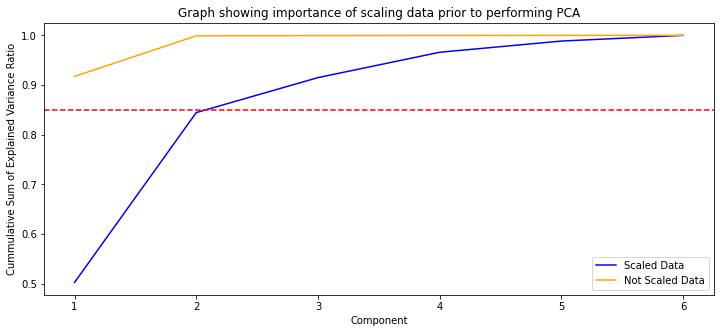

In [20]:
X = dataFrame_titanic_PCA[dataFrame_titanic_PCA.columns[0:6]]
X_scaled = MinMaxScaler(feature_range=[-10,10]).fit_transform(X)
pca_X_scaled = PCA().fit(X_scaled)
plt.figure(figsize=(12,5))

pca_X_not_scaled = PCA().fit(X)
_ = plt.plot([1,2,3,4,5,6], np.cumsum(pca_X_scaled.explained_variance_ratio_), color='blue', label="Scaled Data")
_ = plt.plot([1,2,3,4,5,6], np.cumsum(pca_X_not_scaled.explained_variance_ratio_), color = 'orange', label="Not Scaled Data" )
plt.axhline(0.85, color="red", linestyle = "--")
plt.legend(loc="best")
plt.xlabel("Component")
plt.ylabel("Cummulative Sum of Explained Variance Ratio")
plt.title("Graph showing importance of scaling data prior to performing PCA")
plt.show()

As you can see, if we did not scale our data before performing PCA we under-estimated the number of components we would need to explain the variance ratio. The explained variance is essentially the information pertitent to predicting. A common "rule-of-thumb" is that you need at least enough components to explain 85% of the total explained variance. So we see that even with just two components we can explain about 85% of the data variance. We have reduced the number of components needed to predict the target at some small expense to accuracy. Now we can visualize the data. Let's plot a 2D histogram of our first and second principal components.

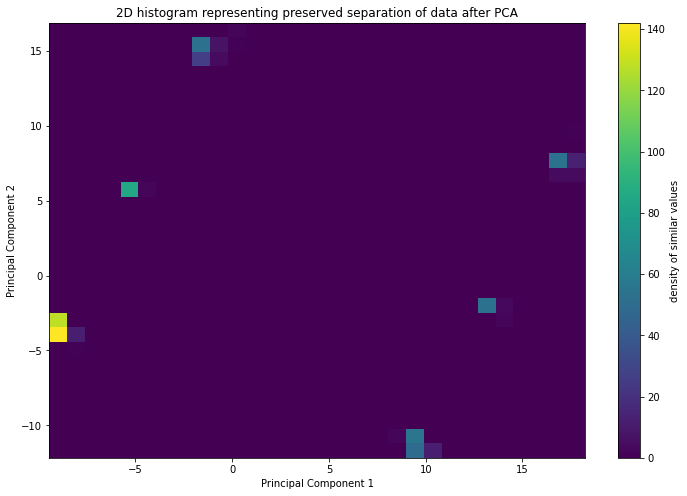

In [21]:
X_pca_scaled = PCA().fit_transform(X_scaled)
plt.figure(figsize = (12,8))
_ = plt.hist2d(X_pca_scaled[:,0], X_pca_scaled[:,1], bins = 30)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("2D histogram representing preserved separation of data after PCA")
cb = plt.colorbar()
cb.set_label('density of similar values')

We can see that the data resolves to at least two clearly defined regions. We can next plot a scatter plot to further visualize how PCA can reduce the amount of data needed to predict targets. Let's plot a scatter plot and assign a color based on the corresponding target for each data point.

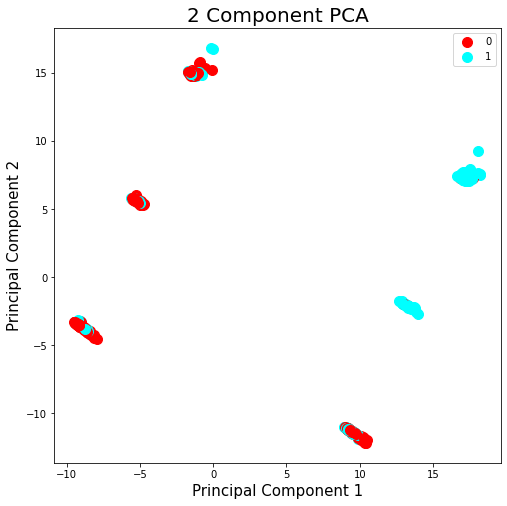

In [22]:
survived_key = {'0': 'red','1': 'cyan'}

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

for index in dataFrame_titanic_PCA.index:
    survived = str(int(dataFrame_titanic_PCA.iloc[index]["Survived"]))
    ax.scatter(X_pca_scaled[index, 0], X_pca_scaled[index, 1], color = survived_key[survived], label = survived, s = 100)
ax.legend(survived_key.keys())
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('cyan')
plt.show()

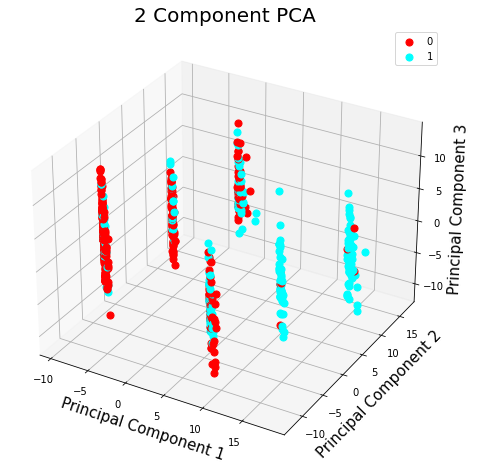

In [23]:
survived_key = {'0': 'red','1': 'cyan'}

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title('2 Component PCA', fontsize = 20)


for index in dataFrame_titanic_PCA.index:
    survived = str(int(dataFrame_titanic_PCA.iloc[index]["Survived"]))
    ax.scatter(X_pca_scaled[index, 0], X_pca_scaled[index, 1], X_pca_scaled[index,2], color = survived_key[survived], label = survived, s = 50)
ax.legend(survived_key.keys())
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('cyan')
plt.show()

If we add the 3rd principal component it makes it marginally easier to distinguish data.

### Correlation Matrix

The final visualization we have at our disposal is a correlation matrix. By comparing the correlation matrix of X and the inverse transform of X after PCA we can observe the "smoothing" effect of applying PCA.

In [24]:
X_pca = PCA(n_components=2).fit(X)
X_inv_transform = X_pca.inverse_transform(X_pca.transform(X))
X_inv_transform = pd.DataFrame(data = X_inv_transform, columns=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'])

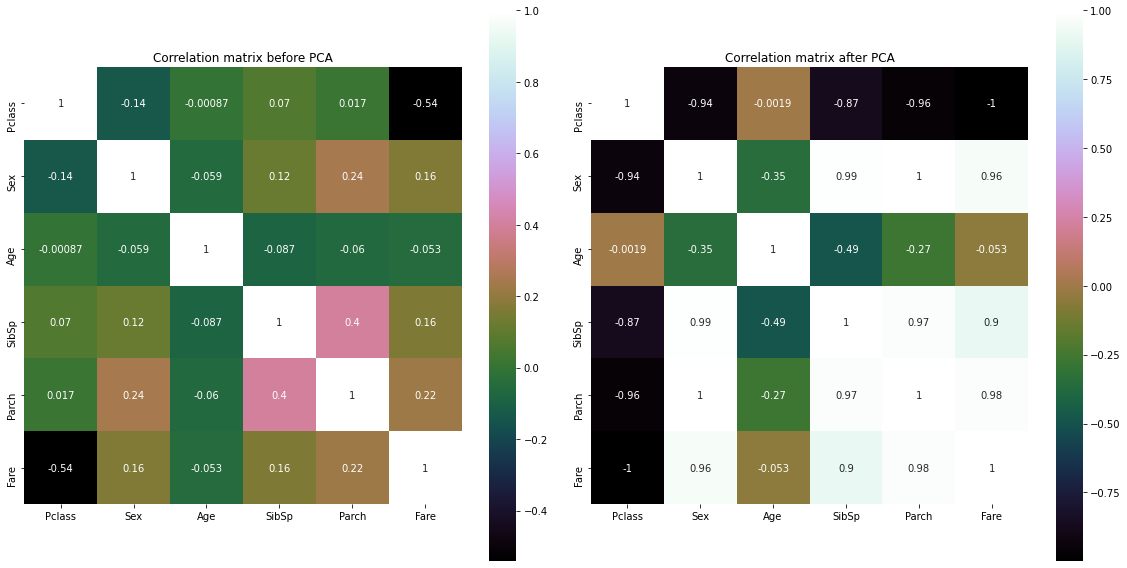

In [25]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
corr_mat = X.corr(method='pearson')
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title("Correlation matrix before PCA")

plt.subplot(1,2,2)

corr_mat = X_inv_transform.corr(method='pearson')
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title("Correlation matrix after PCA")

plt.tight_layout()
plt.show()

# Performing PCA on GECKO data

We can performing some PCA exploration on the GECKO data. We will start with a single experiment first.

In [19]:
dataFrame_gecko = dataFrame

In [20]:
dataFrame_gecko = dataFrame_gecko[dataFrame_gecko.columns[1:34]]

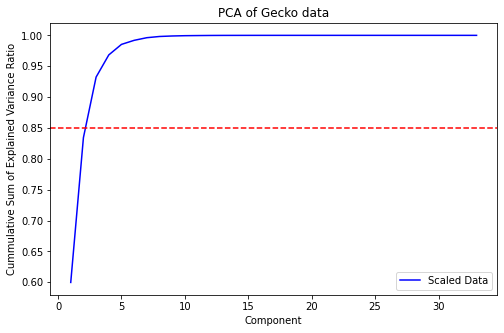

In [21]:
X = dataFrame_gecko
X_scaled = StandardScaler().fit_transform(X)
pca_X_scaled = PCA().fit(X_scaled)
plt.figure(figsize=(8,5))

pca_X_not_scaled = PCA().fit(X)
range_ = [x for x in range(1,34)]
_ = plt.plot(range_, np.cumsum(pca_X_scaled.explained_variance_ratio_), color='blue', label="Scaled Data")
plt.axhline(0.85, color="red", linestyle = "--")
plt.legend(loc="best")
plt.xlabel("Component")
plt.ylabel("Cummulative Sum of Explained Variance Ratio")
plt.title("PCA of Gecko data")
plt.show()

The cummulative sum of explained variance represents how much "information" is being accounted for. The 85% threshold is essentially the goal.

We see that we can quickly reduce the number of components needed; however this is just data from one experiment. In reality the full data set contains parameters that were not held steady, so more components are needed to explain the variance. More on this later. We will move onto experimenting with the full dataset and things will start to come together. 

Something important to note is that you must scale before performing any PCA or your results will not be accurate.

# Exploration of a GECKO dataset with all included experiments

Something that hasn't been discussed is what data is actually needed from the dataframe. The ultimate goal is going to be predicting amount of precursor at t+1 based on available input. It's time to start thinking about what is needed to do that. We will use the following features as input in our model:

* Temperature (K): The temperature at which the GECKO-A experiments were conducted. Temperature will affect the reaction rates of many reactions. It also affects the partitioning of a given compound between the gas-phase and particle-phase.
* Solar zenith angle (degree): The solar zenith angle at which the GECKO-A experiments were conducted. This will affect the photolysis reactions. 
* Pre-existing aerosols (micrograms per cubic meter): Depending on the environmental conditions (e.g., temperature) and the vapor pressure, a compound can deposit onto (pre-existing) aerosols or evaporate from the aerosols. 
* NOx $(molec/cm^3)$: concentration of nitrogen oxides. These are important compounds in the atmosphere, affecting the chemical mechanisms of many volatile organic compounds.
* O3 $(molec/cm^3)$: concentration of ozone. It’s another important compounds in the atmosphere, affecting the chemical mechanisms of many VOCs.
* OH $(molec/cm^3)$: concentration of hydroxyl radicals (OH). It’s one of the most important oxidants in the atmosphere, largely driving the oxidation of many VOCs.
* Gas binned data $(ug/m^3)$: concentration of gas concentration binned by level of volatility 
* Aerosol binned data $(ug/m^3)$: concentration of aerosol conctration binned by level of volatility

We will have to add pre-existing aerosol data to our dataset and we can remove all the bins except those for gas and aerosol. We also will want to add exp # to our data.

## Our dataset (the training data)
The dataset we will be using contains 1600 experiments. Each experiment contains 1440 rows of data so our dataset will contain about 2.3 million rows of data.

In [22]:
dataFrame = fetch_data('ncar-aiml-data-commons/gecko/toluene_train_in_binned.parquet')

In [23]:
dataFrame.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,Gas [ug/m3] Bin05: lg(C*) = -2.5,Gas [ug/m3] Bin06: lg(C*) = -1.5,Gas [ug/m3] Bin07: lg(C*) = -0.5,Gas [ug/m3] Bin08: lg(C*) = 0.5,...,Aerosol [ug_m3] Bin12: lg(C*) = 4.5,Aerosol [ug_m3] Bin13: lg(C*) = 5.5,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.037689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,305.065364,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
1,301.207794,0.037426,2.767639e-17,5.465436e-13,1.420820e-12,4.041857e-12,4.353356e-12,5.635269e-12,6.116312e-12,1.709608e-10,...,1.133111e-11,1.206304e-13,5.079438e-12,304.978044,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
2,601.415588,0.037164,2.772026e-17,5.440976e-13,1.415403e-12,4.287764e-12,4.421259e-11,1.623398e-11,2.802625e-11,1.634808e-09,...,2.606058e-11,4.502163e-13,5.588369e-12,304.890766,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
3,901.623352,0.036904,2.772170e-17,5.417454e-13,1.413397e-12,5.737255e-12,1.927043e-10,4.042448e-11,8.991534e-11,5.784281e-09,...,4.304783e-11,9.602400e-13,6.075447e-12,304.803571,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
4,1201.831177,0.036646,2.803421e-17,5.397588e-13,1.422216e-12,1.059735e-11,5.276418e-10,8.292556e-11,2.145164e-10,1.374481e-08,...,6.160334e-11,1.625196e-12,6.543917e-12,304.716502,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0


# How are the data distributed overall?

Let's check out how the data is distributed. First let's scale the data and then we will plot a matrix of histrograms to see how the data is distributed. 

In [24]:
dataFrame_hist = dataFrame.drop(columns = ["Time [s]", "id"])

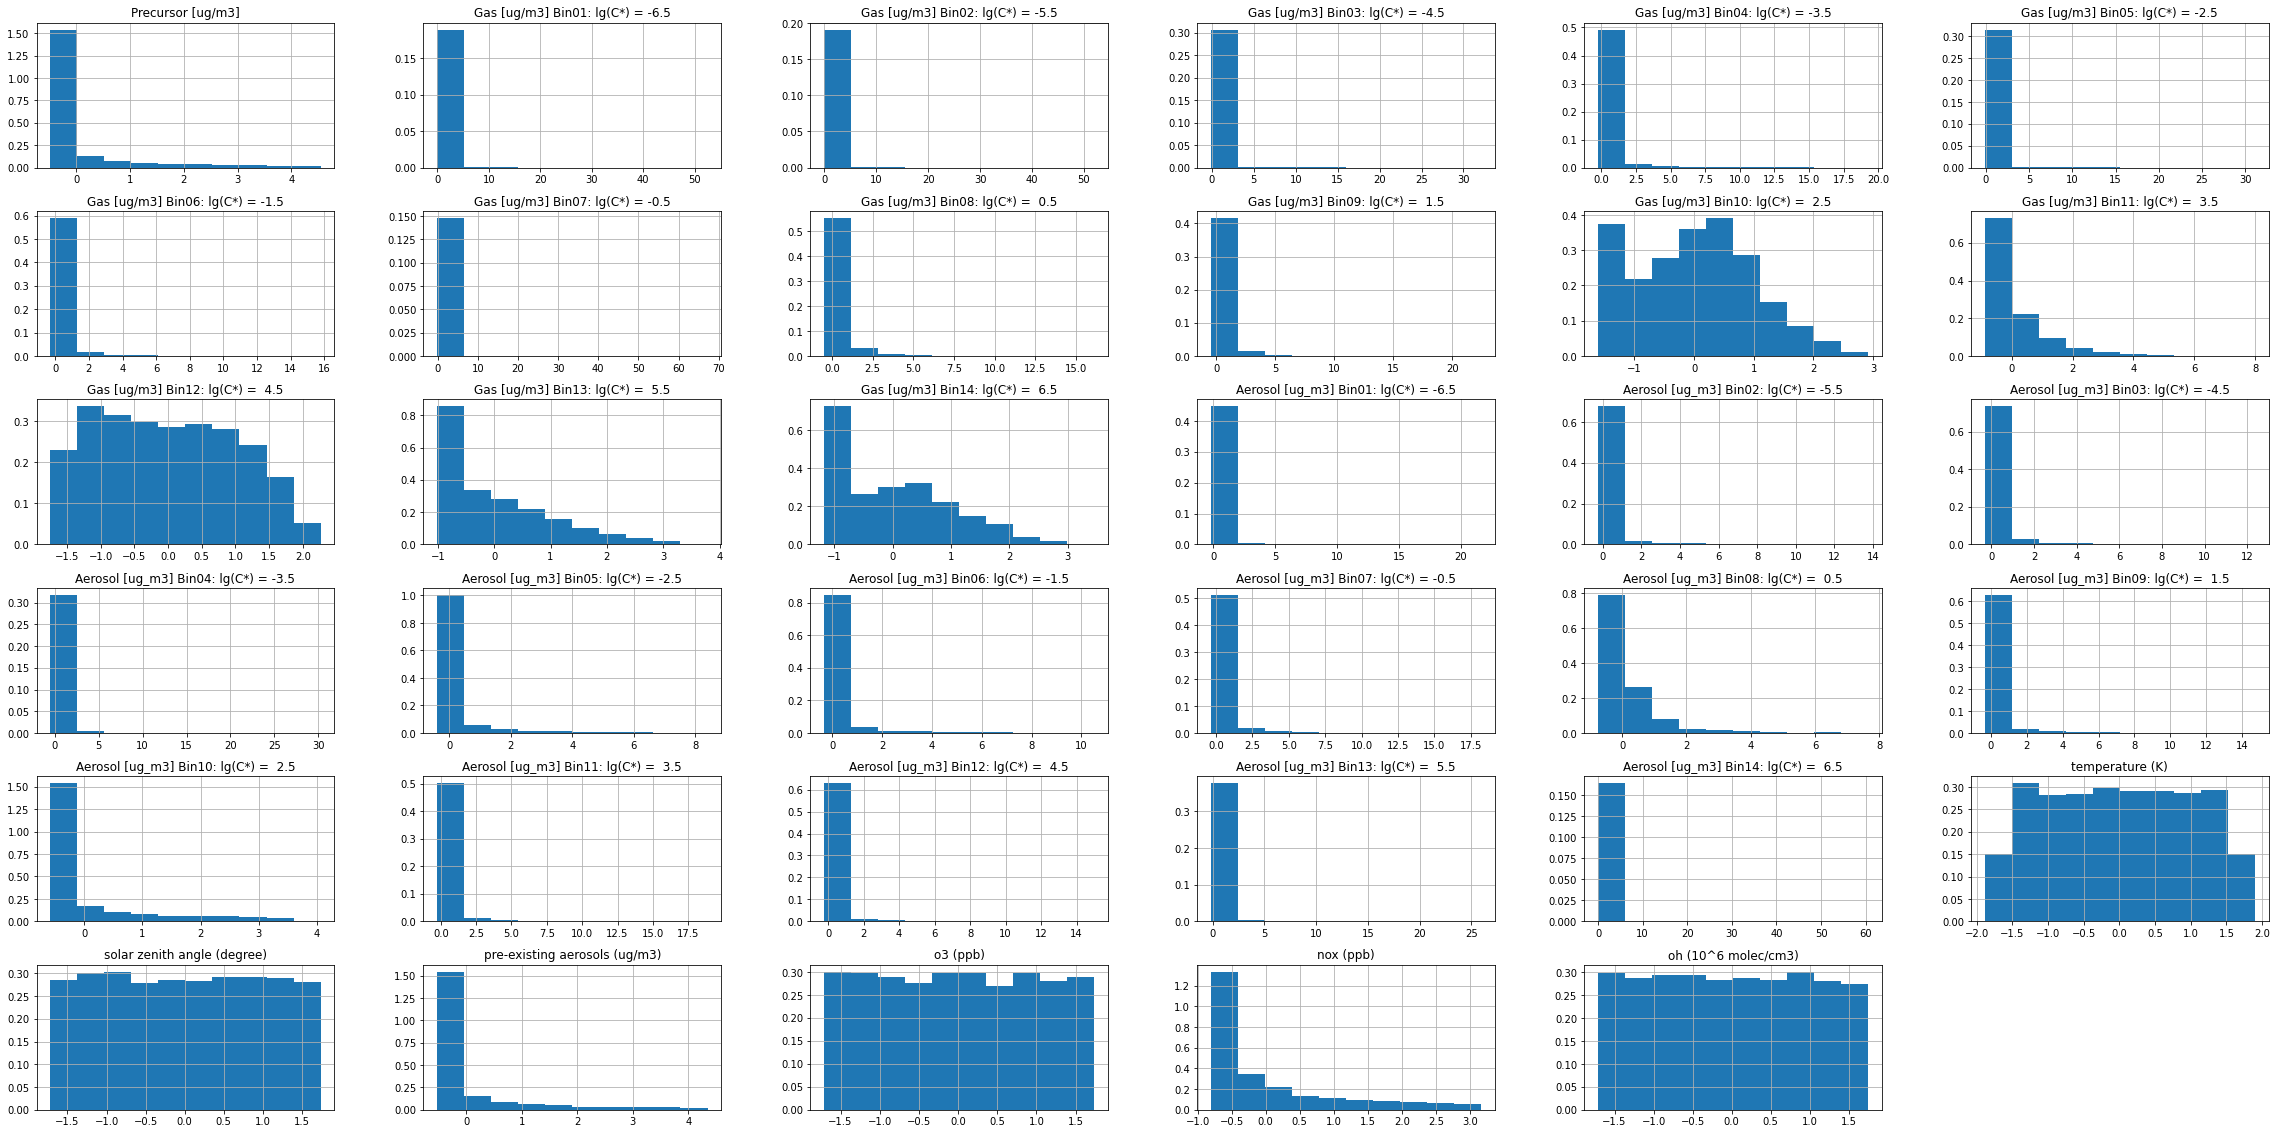

In [25]:
columns = dataFrame_hist.columns
dataFrame_scaled = StandardScaler().fit_transform(dataFrame_hist)

dataFrame_scaled = pd.DataFrame(data=dataFrame_scaled, columns=columns)
_ = dataFrame_scaled.hist(figsize=(40,20), density = True)

Some of the fields are seriously skewed. This could be problematic for a model. We want distributions that resemble uniform or guassian. One thing we can do is log transform the features that are highly skewed. We will scale the data to between 1e-12 and 1 so that we can avoid log(0) errors. After log transforming the features that appear skewed, we will apply a Z-score standarization to fit each column to have a mean of 0 and a std deviation of 1.  

In [26]:
data_frame_min_max_scale = MinMaxScaler((1e-12,1)).fit_transform(dataFrame_hist)

Now perform log transform.

In [27]:
columns_to_log_transform=['Precursor [ug/m3]', 'nox (ppb)','pre-existing aerosols (ug/m3)',
       'Gas [ug/m3] Bin01: lg(C*) = -6.5', 'Gas [ug/m3] Bin02: lg(C*) = -5.5',
       'Gas [ug/m3] Bin03: lg(C*) = -4.5', 'Gas [ug/m3] Bin04: lg(C*) = -3.5',
       'Gas [ug/m3] Bin05: lg(C*) = -2.5', 'Gas [ug/m3] Bin06: lg(C*) = -1.5',
       'Gas [ug/m3] Bin07: lg(C*) = -0.5', 'Gas [ug/m3] Bin08: lg(C*) =  0.5',
       'Gas [ug/m3] Bin09: lg(C*) =  1.5',
       'Gas [ug/m3] Bin11: lg(C*) =  3.5',
       'Gas [ug/m3] Bin13: lg(C*) =  5.5', 'Gas [ug/m3] Bin14: lg(C*) =  6.5',
       'Aerosol [ug_m3] Bin01: lg(C*) = -6.5',
       'Aerosol [ug_m3] Bin02: lg(C*) = -5.5',
       'Aerosol [ug_m3] Bin03: lg(C*) = -4.5',
       'Aerosol [ug_m3] Bin04: lg(C*) = -3.5',
       'Aerosol [ug_m3] Bin05: lg(C*) = -2.5',
       'Aerosol [ug_m3] Bin06: lg(C*) = -1.5',
       'Aerosol [ug_m3] Bin07: lg(C*) = -0.5',
       'Aerosol [ug_m3] Bin08: lg(C*) =  0.5',
       'Aerosol [ug_m3] Bin09: lg(C*) =  1.5',
       'Aerosol [ug_m3] Bin10: lg(C*) =  2.5',
       'Aerosol [ug_m3] Bin11: lg(C*) =  3.5',
       'Aerosol [ug_m3] Bin12: lg(C*) =  4.5',
       'Aerosol [ug_m3] Bin13: lg(C*) =  5.5',
       'Aerosol [ug_m3] Bin14: lg(C*) =  6.5']

In [28]:
dataFrame_log_transformed = pd.DataFrame(data=data_frame_min_max_scale, columns=columns)

In [29]:
for column in columns_to_log_transform:
    try:
        dataFrame_log_transformed[column] = np.log2(dataFrame_log_transformed[column])
    except (ValueError, AttributeError):
        pass

Scale data using Z-score scaling.

In [30]:
dataFrame_log_tranform_scaled = StandardScaler().fit_transform(dataFrame_log_transformed)

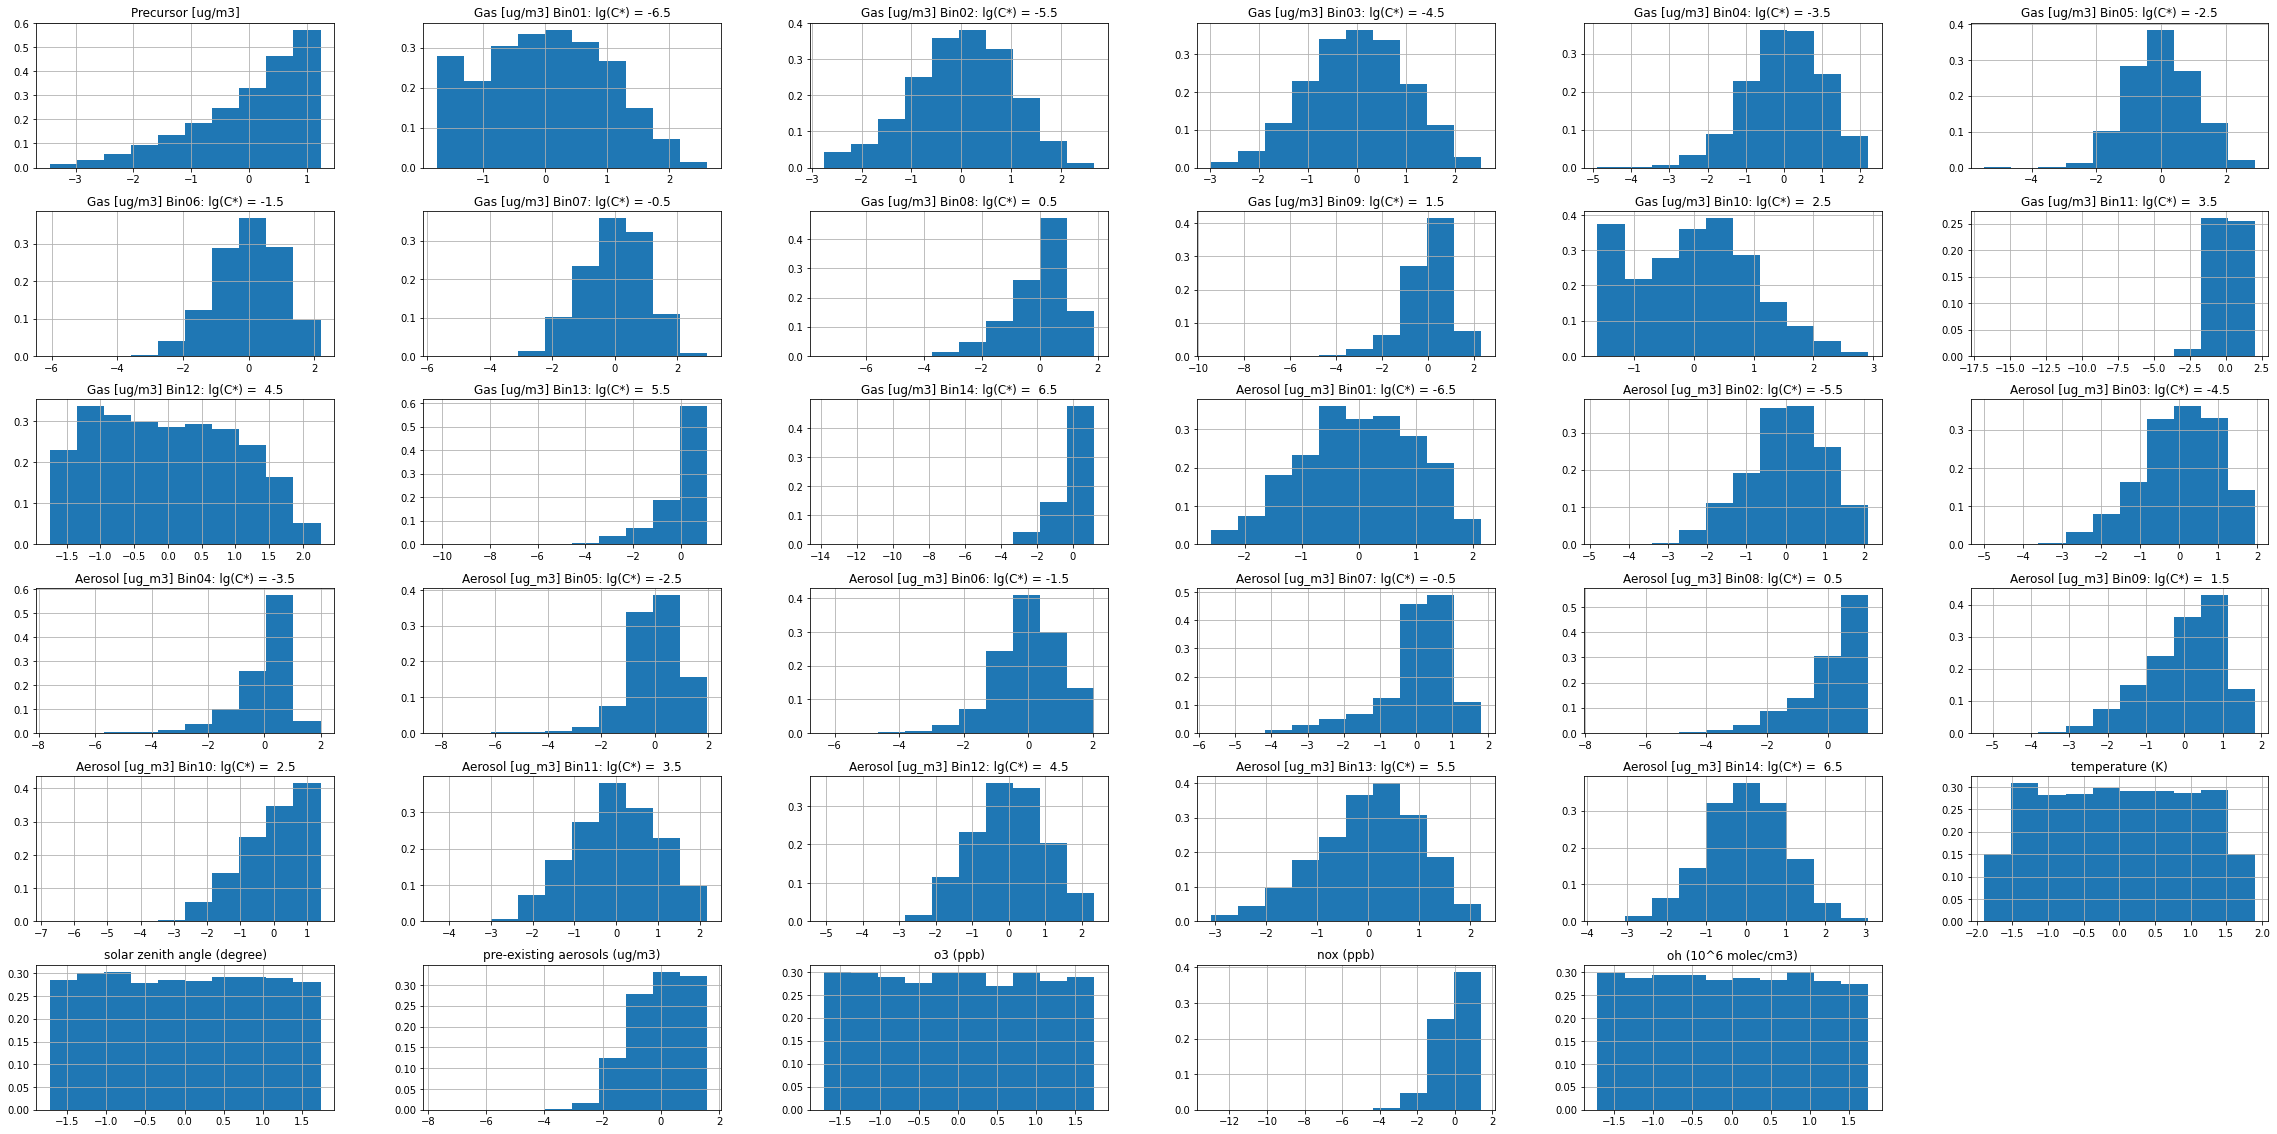

In [31]:
dataFrame_log_tranform_scaled = pd.DataFrame(data=dataFrame_log_tranform_scaled, columns=columns)
_ = dataFrame_log_tranform_scaled.hist(figsize=(40,20), density = True)

Now we see a much more even distribution for each parameter.

# Correlation of data and PCA

We can see in the plots of our data that some of the gas and aersol bins follow similar looking distributions. It may be worth it to figure out how that data are correlated and investigate how we might reduce the dimension of our data through shrinking the bin count.

Let's plot a correlation matrix.

## Correlation Matrix

Now that we know some scaling methods we can go ahead and expand our data frame to include other experiments and do some further exploration by building a correlation matrix. This will help us determine what features my be linear combinations of other features. We can call on Principal component analysis to reduce the dimension of our data by abstracting away linearly correlated data.

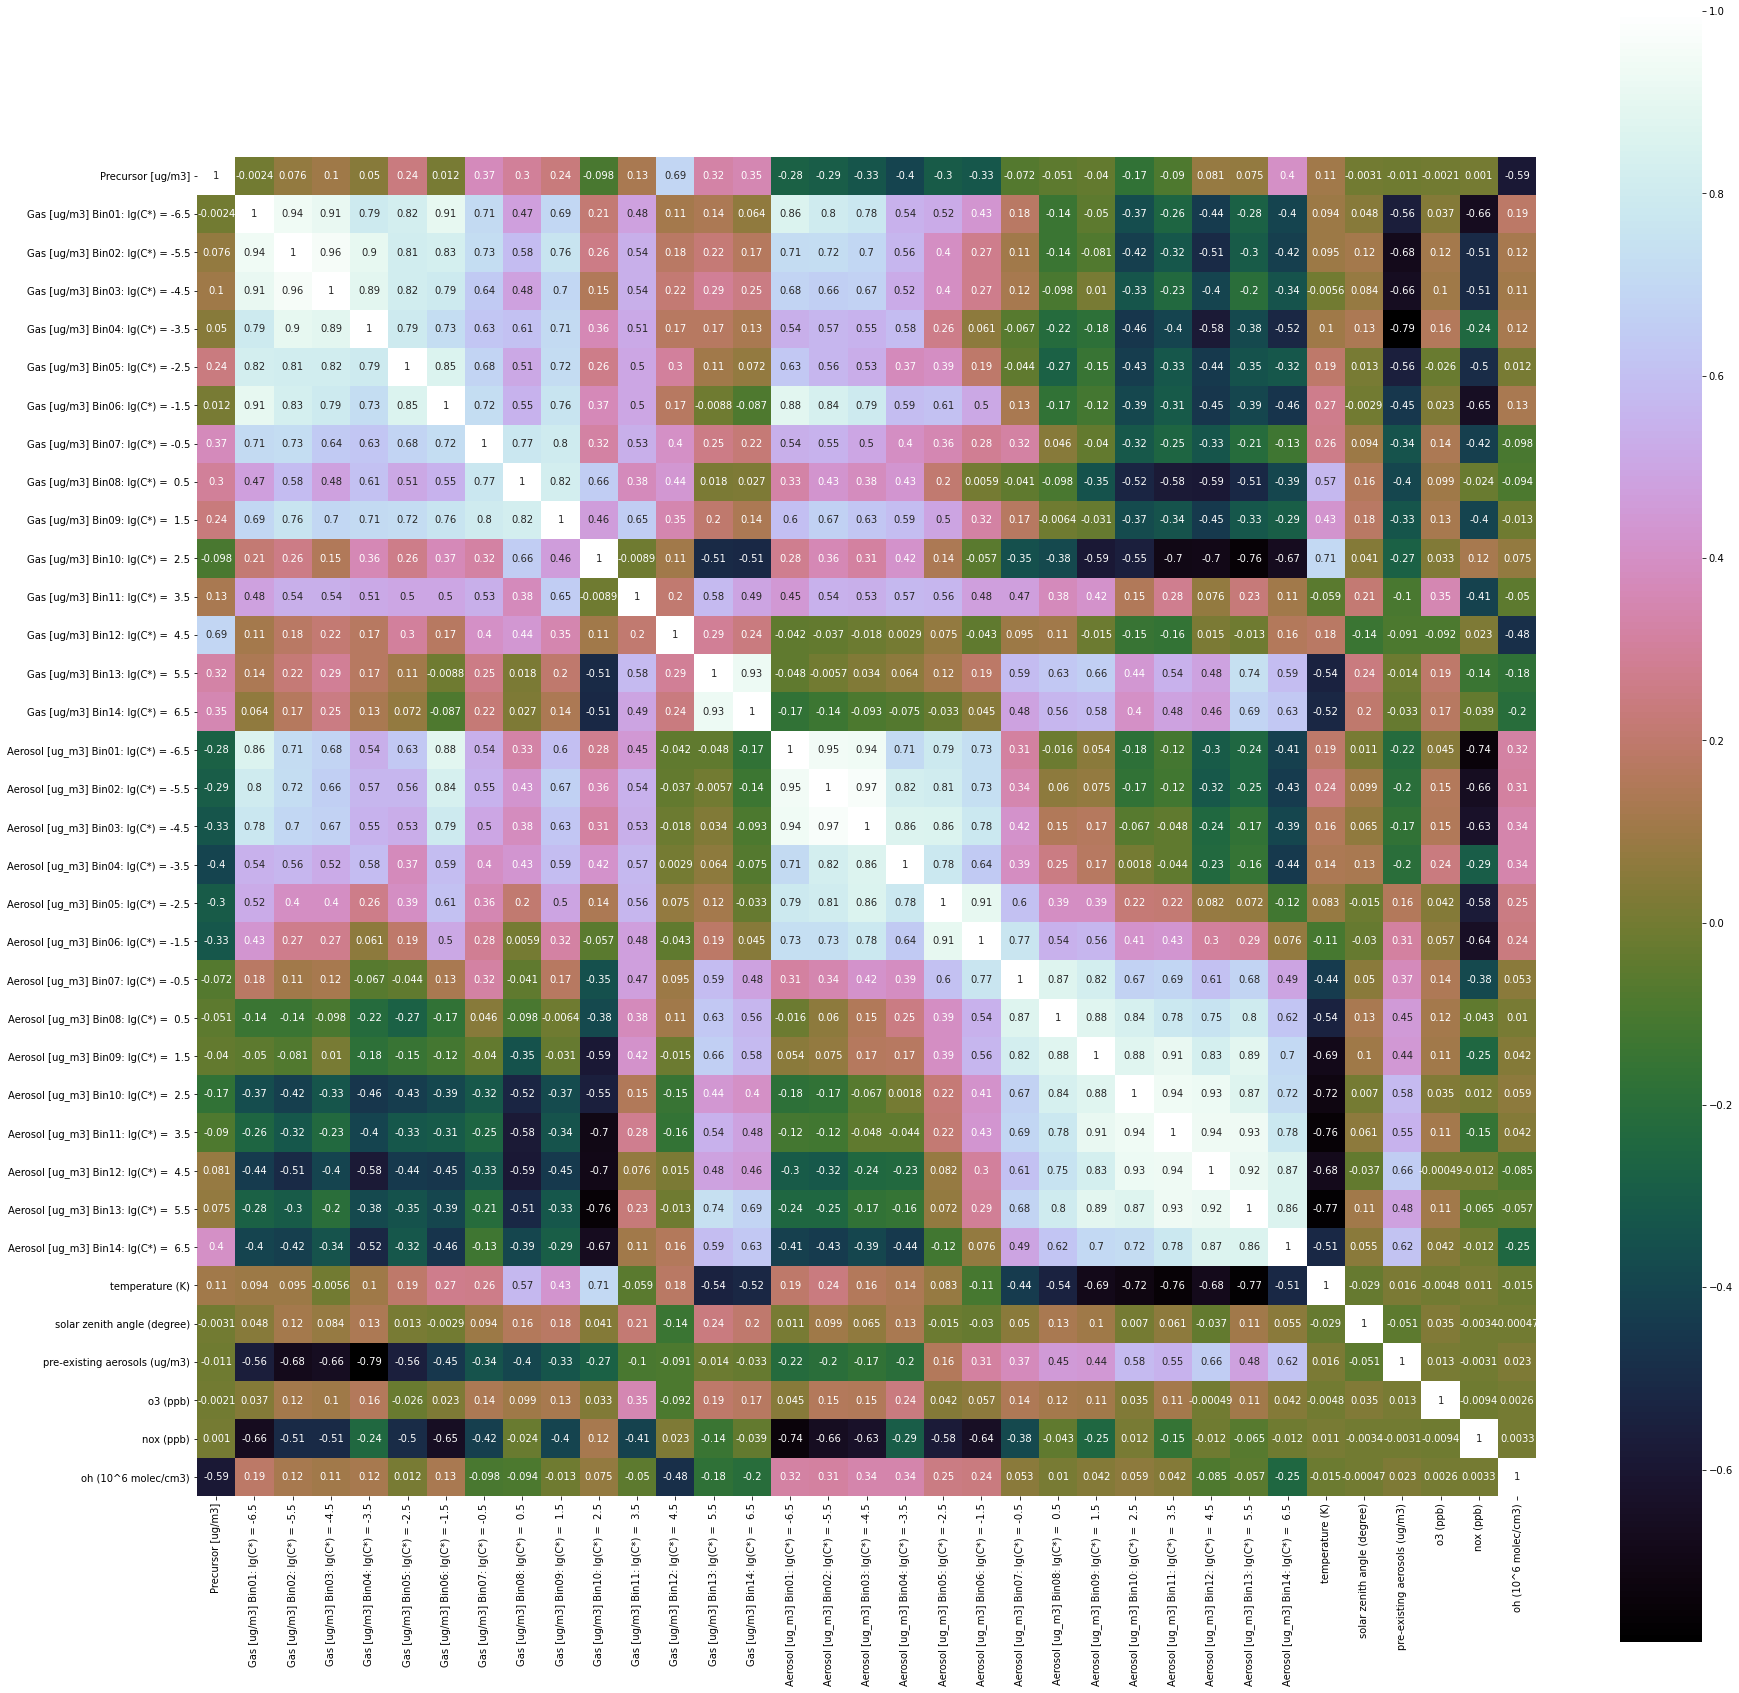

In [32]:
corr_mat = dataFrame_log_tranform_scaled.corr(method='pearson')
plt.figure(figsize=(30,30))
_ = sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

The correlation matrix shows high correlation between individual gas bins and high correlation among binned aerosol data. There are some outliers however such as gas bins 10,12,13, and 14 which suggests that we cannot just combine all the gas bins and and expect an advantage in model prediction. Rather than do something like sum the gas bins we could perform PCA to try to shrink the number of bins needed to represent gas data.

## PCA

In [33]:
dataFrame_pca = dataFrame_log_tranform_scaled
dataFrame_pca.head()

,Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,Gas [ug/m3] Bin05: lg(C*) = -2.5,Gas [ug/m3] Bin06: lg(C*) = -1.5,Gas [ug/m3] Bin07: lg(C*) = -0.5,Gas [ug/m3] Bin08: lg(C*) = 0.5,Gas [ug/m3] Bin09: lg(C*) = 1.5,...,Aerosol [ug_m3] Bin11: lg(C*) = 3.5,Aerosol [ug_m3] Bin12: lg(C*) = 4.5,Aerosol [ug_m3] Bin13: lg(C*) = 5.5,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
0,1.240635,-1.747653,-2.759108,-2.982686,-4.882361,-5.455954,-6.050117,-5.697315,-7.452767,-9.450591,...,-4.295177,-5.065853,-3.090449,-3.743623,1.264372,0.281657,-1.503351,0.318395,0.527572,-0.462152
1,1.239447,-0.918320,-0.156164,-0.620586,-1.895284,-2.699058,-2.588895,-2.452157,-2.881823,-2.842802,...,-3.492712,-3.065550,-2.315684,-0.851664,1.260383,0.281657,-1.503351,0.318395,0.527572,-0.462152
2,1.238257,-0.918072,-0.157044,-0.621350,-1.880141,-1.998962,-2.273321,-1.974317,-2.118744,-2.235382,...,-3.274104,-2.842163,-2.065413,-0.828103,1.256395,0.281657,-1.503351,0.318395,0.527572,-0.462152
3,1.237068,-0.918063,-0.157895,-0.621634,-1.805475,-1.554330,-2.001213,-1.608371,-1.691682,-1.900776,...,-3.127669,-2.707525,-1.920525,-0.807483,1.252411,0.281657,-1.503351,0.318395,0.527572,-0.462152
4,1.235878,-0.916304,-0.158616,-0.620390,-1.648145,-1.250107,-1.786913,-1.335409,-1.399165,-1.669630,...,-3.014192,-2.611371,-1.819710,-0.789155,1.248432,0.281657,-1.503351,0.318395,0.527572,-0.462152


Let's plot the cummulative explained variance ratio as a function of number of principal components.


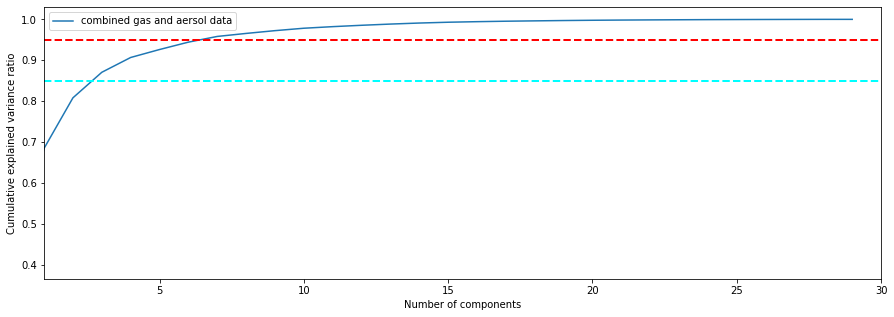

In [34]:
pca = PCA().fit(dataFrame_pca[dataFrame_pca.columns[0:30]])
plt.figure(figsize=(15,5))

plt.plot(np.cumsum(pca.explained_variance_ratio_), label = "combined gas and aersol data")
plt.legend(loc='best')

plt.xlim(1,30,0.5)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.axhline(y = 0.95, color='r',linestyle='--' , linewidth=2)
plt.axhline(y = 0.85, color='cyan',linestyle='--' , linewidth=2)

plt.show()
plt.close()

## Stop and Ask

We have performed PCA on all the data and plotted the cummulative explained variance ratio. Try just selecting some features and performing PCA. How does this change things?

What if we plot the first and second components across all features? What does this show?

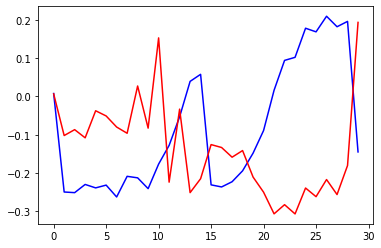

In [35]:
plt.plot(pca.components_[0], color = "blue")
plt.plot(pca.components_[1], color = "red")

### Correlation Matrix and Inverse Transform of PCA

We can compare the correlation matrix of the training data with the matrix of the inverse transform of applying PCA. See how applying pca make the features that are correlated more pronounced and has a smoothing effect?

In [36]:
pca = PCA(n_components=4).fit(dataFrame_pca)
pca_inv_transform = pca.inverse_transform(pca.transform(dataFrame_pca))

dataFrame_pca_inverse_transform = pd.DataFrame(data = pca_inv_transform, columns=columns)

<AxesSubplot:>

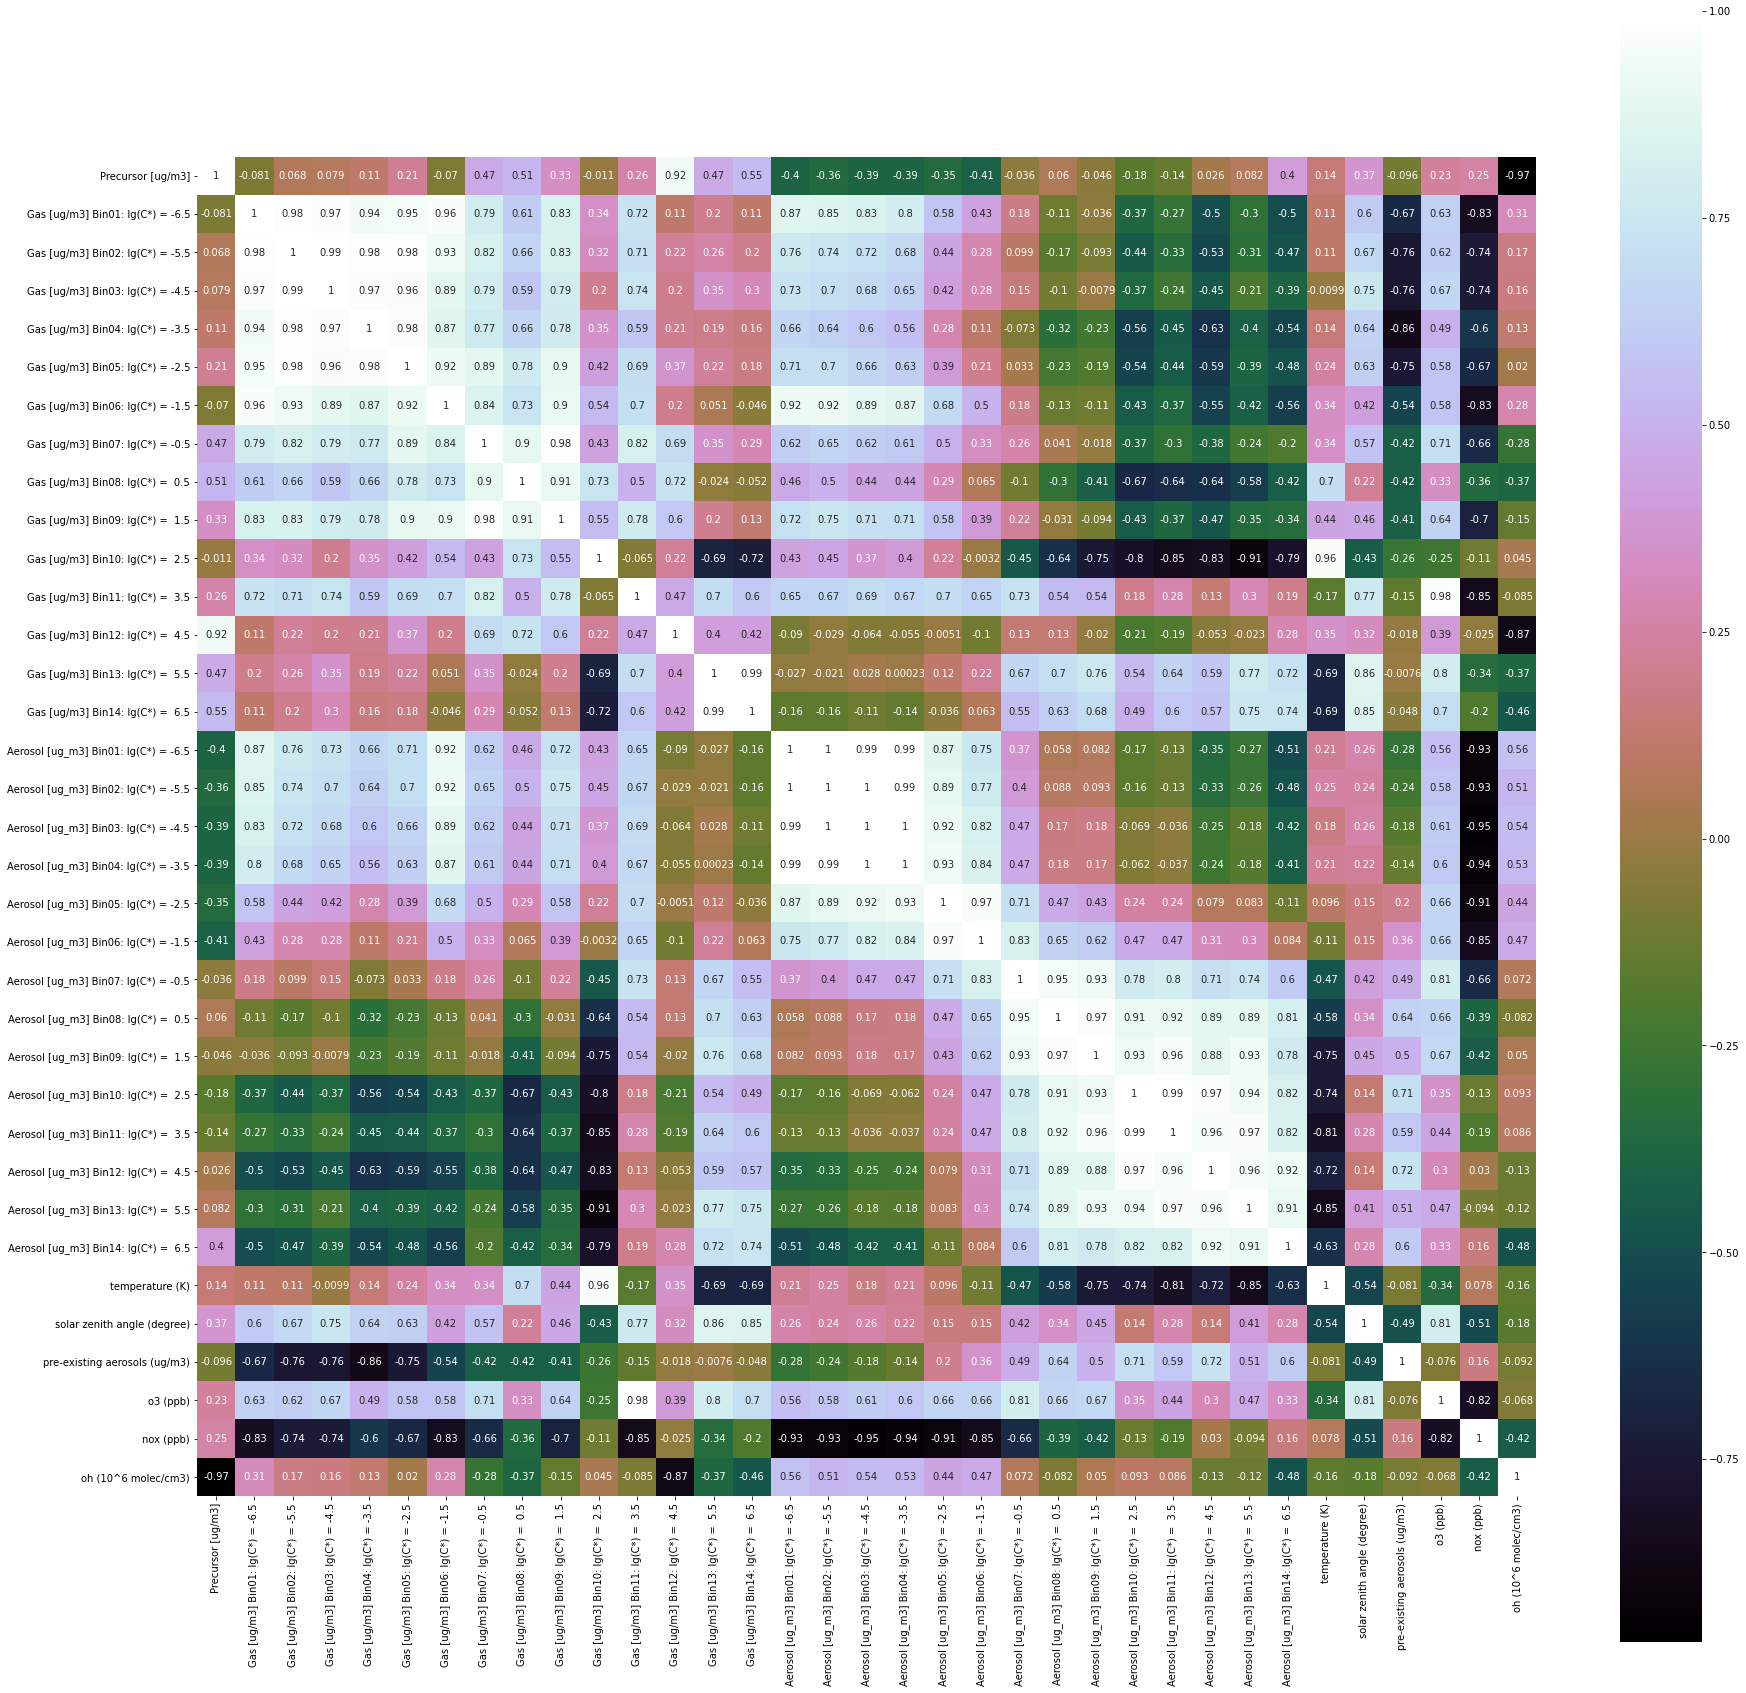

In [37]:
corr_mat = dataFrame_pca_inverse_transform.corr(method='pearson')
plt.figure(figsize=(30,30))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

## Stop and Ask

What can we say about the correlation matrix? What is there left to explore?

Read the following [link on PCA](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) to gain a better understanding of this valuable technique.

### PCA Analysis of Binned Gas data and Aerosol Data

Because the correlation matrix suggests some values like the Gas binned data 1 through 9 is correlated there may be reason to try PCA analysis as a way to reduce the dimension of our feature matrix. PCA is a way of essentially smoothing out the surface represented by the matrix of input features in our model. Sklearn contains a library of functions that can assist in performing PCA. We have already gone through several examples where we fit PCA and then transform the data.

Let's just perform PCA on the binned gas data and then the binned aerosol data. 

In [38]:
dataFrame_gas_binned = dataFrame[dataFrame.columns[2:16]]
dataFrame_aerosol_binned = dataFrame[dataFrame.columns[16:30]]

In [39]:
dataFrame_gas_binned_scaled = StandardScaler().fit_transform(dataFrame_gas_binned)
dataFrame_aerosol_binned_scaled = StandardScaler().fit_transform(dataFrame_aerosol_binned)

In [44]:
def plot_pca(data, label):
    
    pca = PCA().fit(data)
    plt.figure(figsize=(15,5))

    plt.plot(np.cumsum(pca.explained_variance_ratio_), label = label)
    plt.legend(loc='best')

    plt.xlim(0,14,0.5)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance ratio')
    plt.axhline(y = 0.95, color='r',linestyle='--' , linewidth=2)
    plt.axhline(y = 0.85, color='cyan',linestyle='--' , linewidth=2)

    plt.show()
    plt.close()

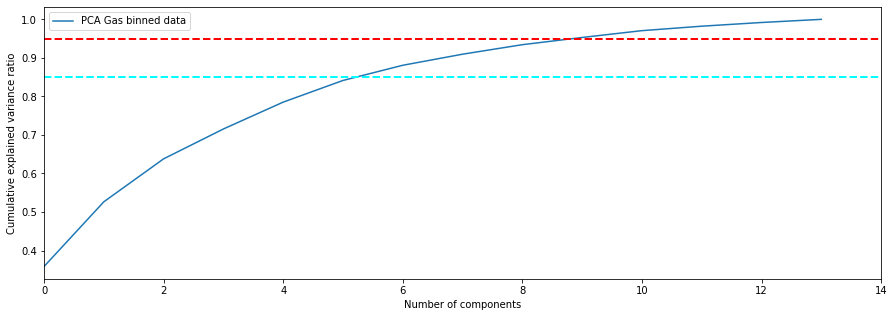

In [45]:
plot_pca(dataFrame_gas_binned_scaled, "PCA Gas binned data")

In [ ]:
plot_pca(dataFrame_aerosol_binned_scaled, "PCA Aerosol binned data")

# Recap

We have learned how to analyze our data by checking the typ and how it is distributed, and have explored some techniques to transform our data and reduce the size of our data. Think about how you might reduce the size of the binned data sets. Would you aggregate the ones with high correlation? In the following notebook we will be using an aggregated dataset where the gas an aersol bins were summed.